c:\users\drich\pycharmprojects\reconstruction\venv\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\users\drich\pycharmprojects\reconstruction\venv\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\users\drich\pycharmprojects\reconstruction\venv\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\users\drich\pycharmprojects\reconstruction\venv\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\users\drich\pycharmprojects\reconstruction\venv\lib\site-pack

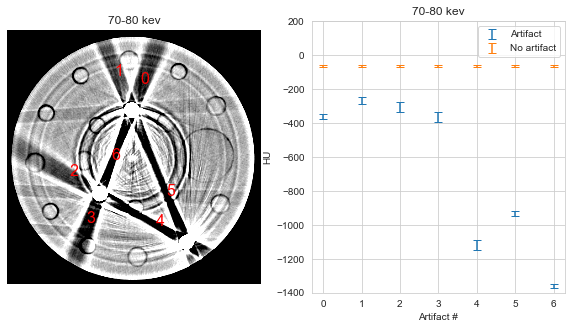

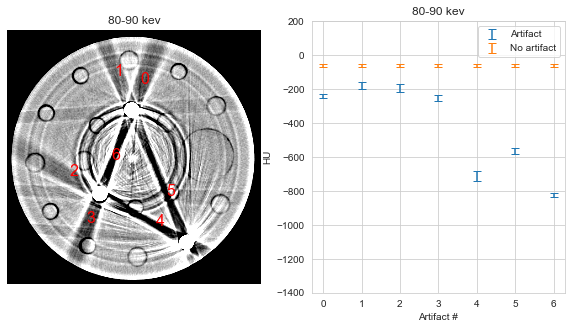

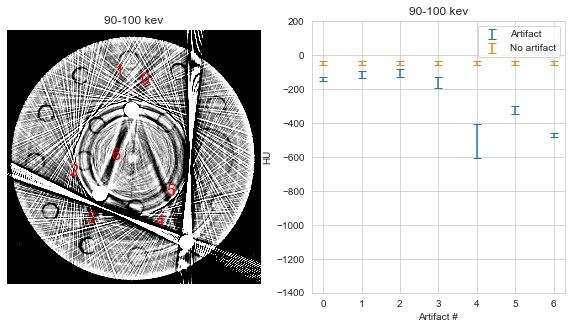

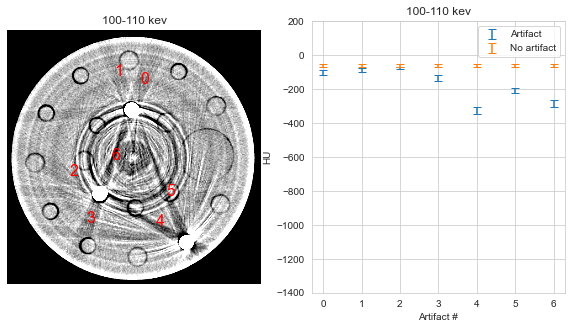

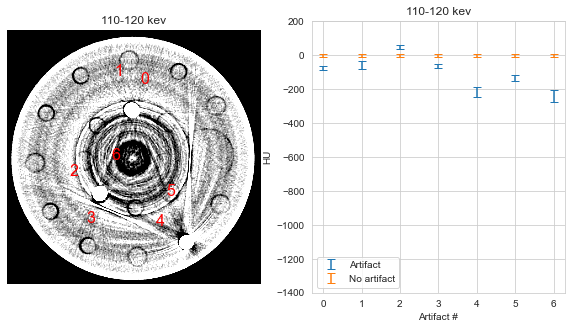

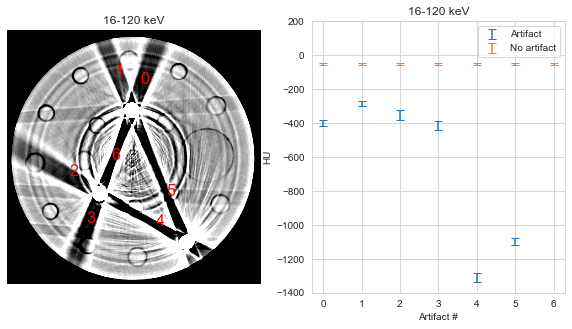

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

directory = r'D:\OneDrive - University of Victoria\Research\LDA Data'
folder = '21-05-12_CT_metal'
sub = 'metal_in'

bin_width = 1  # Multiples of 10
thresholds = [70, 80, 90, 100, 110, 120]

num_artifacts = 7
slices = [11, 14]  # Includes slices[1] in good slices
num_z = (slices[1] + 1) - slices[0]
# Load the metal artifact data
data = np.load(os.path.join(directory, folder, sub, 'Norm CT', 'CT_norm.npy'))[:, slices[0]:slices[1]+1]
num_bins = np.shape(data)[0]
phantom_mask = np.load(os.path.join(directory, folder, sub, f'no_artifact_mask.npy'))

mean_data = np.zeros((num_bins, num_z, num_artifacts))
phant_data = np.zeros((num_bins, num_z, num_artifacts))
artifact_pix = np.zeros((num_artifacts, 2))
for i in range(num_bins):
    for z in range(num_z):
        phant_data[i, z, :] = np.nanmean(data[i, z]*phantom_mask)
        for a in range(num_artifacts):
            artifact_mask = np.load(os.path.join(directory, folder, sub, f'artifact_mask_{a}.npy'))
            mean_data[i, z, a] = np.nanmean(data[i, z]*artifact_mask)
            artifact_pix[a] = np.argwhere(artifact_mask == 1)[10]

# Get the std and mean of the artifacts over the slices
std_data = np.std(mean_data, axis=1)
mean_data = np.mean(mean_data, axis=1)

std_phant = np.std(phant_data, axis=1)
mean_phant = np.mean(phant_data, axis=1)

# Get the title labels
labels = []
if bin_width == 1:
    for i in range(num_bins-bin_width):
        labels.append(f'{thresholds[i]}-{thresholds[i+1]} kev')
    labels.append('16-120 keV')
else:
    for i in range(num_bins):
        labels.append(f'{thresholds[i]}-{thresholds[i+(bin_width)]} kev')

# This is the figure with mean values within the artifacts
sns.set_style('whitegrid')
for i in range(num_bins):
    fig1, ax1 = plt.subplots(1, 2, figsize=(10, 5))
    ax1[0].axis('off')
    ax1[0].imshow(data[i, 1], cmap='gray', vmin=-400, vmax=100)
    for a in range(num_artifacts):

        ax1[0].annotate(f'{a}', (artifact_pix[a, 1], artifact_pix[a, 0]), color='red', fontsize=16)
        # mask = np.load(os.path.join(directory, folder, sub, f'artifact_mask_{a}.npy'))
        # ax1[0].imshow(mask, alpha=0.8)
    ax1[0].set_xlim([138, 440])
    ax1[0].set_ylim([138, 440])
    ax1[0].set_title(labels[i])
    ax1[1].errorbar(np.arange(num_artifacts), mean_data[i], yerr=std_data[i], capsize=4, fmt='none', color='C0')
    ax1[1].errorbar(np.arange(num_artifacts), mean_phant[i], yerr=std_phant[i], capsize=4, fmt='none', color='C1')
    ax1[1].legend(['Artifact', 'No artifact'])
    ax1[1].set_title(labels[i])
    ax1[1].set_ylim([-1400, 200])
    ax1[1].set_ylabel('HU')
    ax1[1].set_xlabel('Artifact #')
    fig1.show()
    fig1.savefig(os.path.join(directory, folder, sub, f'Bin{i}_artifact_vals.png'), dpi=500)